In [3]:
# install torchvision and kaggle
!pip install torchvision
!pip install kaggle

     |████████████████████████████████| 5.9 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 748.8 MB 12 kB/s s eta 0:00:013  |                                | 337 kB 44.5 MB/s eta 0:00:17     |██████▉                         | 159.1 MB 89.7 MB/s eta 0:00:07     |███████████▏                    | 260.6 MB 94.8 MB/s eta 0:00:06     |███████████▌                    | 270.2 MB 94.8 MB/s eta 0:00:06     |██████████████▌                 | 339.3 MB 89.7 MB/s eta 0:00:05     |██████████████████              | 420.6 MB 105.4 MB/s eta 0:00:04     |███████████████████▋            | 459.4 MB 105.4 MB/s eta 0:00:03     |████████████████████▉           | 488.5 MB 93.7 MB/s eta 0:00:03     |████████████████████████████▉   | 673.8 MB 29.5 MB/s eta 0:00:03     |███████████████████████████████▏| 728.1 MB 29.5 MB/s eta 0:00:01     |███████████████████████████████▎| 732.5 MB 29.5 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.2.0
    Uninstalling t

In [ ]:
# download dataset and extract it
! export KAGGLE_USERNAME="roshanshrestha21" && export KAGGLE_KEY="905177b75e3024b5d0edc9166a6d48c1" && kaggle datasets download --unzip vipoooool/new-plant-diseases-dataset
! ls

In [4]:
! pwd && ls
print("\nFolders(classess) in training folder: ...")
! cd "New Plant Diseases Dataset(Augmented)" && ls && cd "New Plant Diseases Dataset(Augmented)" && cd train && ls

/home/wsuser/work

Folders(classess) in training folder: ...
/usr/bin/sh: line 0: cd: New Plant Diseases Dataset(Augmented): No such file or directory


In [6]:
! ls


In [18]:
#import  needed libraries and check the used gpu
import torch
from torch import nn,optim
from torchvision import transforms, models ,datasets
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid

AttributeError: module 'torch.jit' has no attribute 'unused'

In [14]:
%matplotlib inline

NPDD=np.array(glob.glob('test/test/*')) 

fig = plt.figure(figsize=(35, 35))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(5, 7),  
                 axes_pad=0,  # pad between axes in inch.
                 )
l=0
for img in NPDD:
        im=plt.imread(img)
        grid[l].imshow(im,cmap='gray',interpolation='nearest')
        grid[l].text(5,20, img.split('/test/')[1].split('.')[0] ,fontsize=30)
        l+=1

NameError: name 'np' is not defined

In [4]:
#creating the dataloaders 

# Define transforms for the training data and testing data
train_path='train'
valid_path='valid'

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


In [5]:
# load data to loaders
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(valid_path, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=512)

#print used Device
print(f"Device used: {torch.cuda.get_device_name(0)}")

#print class to index mapping
print(f"class to index mapping: {train_data.class_to_idx}")

Device used: Tesla K80
class to index mapping: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_b

In [6]:
# choose a pretrained model to start with check options here: https://pytorch.org/docs/stable/torchvision/models.html
model = models.mobilenet_v2(pretrained=True)

# Freeze parameters of the tarined network 
for param in model.parameters():
    param.requires_grad = False
    
#print the model to check the classifer and change it
print (model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [7]:
# define new classifier and append it to network but remember to have a 29-neuron output layer for our two classes.
model.classifier= nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                nn.Linear(in_features=1280, out_features=38, bias=True),
                                nn.LogSoftmax(dim=1))

# unlock last three blocks before the classifier(last layer).
for p in model.features[-3:].parameters():
    p.requires_grad = True  

    
# choose your loss function
criterion = nn.NLLLoss()

# define optimizer to train only the classifier and the previous three block.
optimizer = optim.Adam([{'params':model.features[-1].parameters()},
                        {'params':model.features[-2].parameters()},
                        {'params':model.features[-3].parameters()},
                        {'params':model.classifier.parameters()}], lr=0.0005)

# define Learning Rate scheduler to decrease the learning rate by multiplying it by 0.1 after each epoch on the data.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

#print the classifier now
print(model.classifier)

#print the whole model
# print(model)

Sequential(
  (0): Dropout(p=0.6, inplace=False)
  (1): Linear(in_features=1280, out_features=38, bias=True)
  (2): LogSoftmax(dim=1)
)


image number 21
---------------------
label: Tomato___Bacterial_spot
prediction: Apple___Black_rot


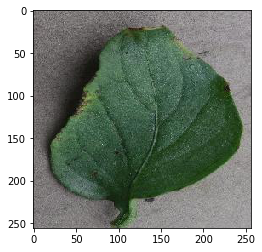

In [8]:
### try your model on some images
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#turn model to evaluation mode
model.eval()

#load some of the test data 
test_data_t = datasets.ImageFolder(valid_path,transforms.Compose([transforms.ToTensor()]))
testloader_t = torch.utils.data.DataLoader(test_data_t, batch_size=200,shuffle=True)
images_t , labels_t=next( iter(testloader_t) )

#Choose arandom image from 0 to 199
index = np.random.randint(0, 199)
test_img=images_t[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0).cuda()

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels_t[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])

In [9]:
#Define number of epochs through data and run the training loop
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 2
step = 0
running_loss = 0
print_every = 5
trainlossarr=[]
testlossarr=[]
oldacc=0

steps=math.ceil(len(train_data)/(trainloader.batch_size))

In [10]:
%%time

for epoch in range(epochs):
    print(f"--------------------------------- START OF EPOCH [ {epoch+1} ] >>> LR =  {optimizer.param_groups[-1]['lr']} ---------------------------------\n")
    for inputs, labels in trainloader:
        model.train()
        step += 1
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        props = model.forward(inputs)
        loss = criterion(props, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step % print_every == 0) or (step==steps):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(props)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
 
                    
                        

            print(f"Epoch ({epoch+1} of {epochs}) ... "
                  f"Step  ({step:3d} of {steps}) ... "
                  f"Train loss: {running_loss/print_every:.3f} ... "
                  f"Test loss: {test_loss/len(testloader):.3f} ... "
                  f"Test accuracy: {accuracy/len(testloader):.3f} ")
            trainlossarr.append(running_loss/print_every)
            testlossarr.append(test_loss/len(testloader))
            running_loss = 0
            
        
    scheduler.step()
    step=0

--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.0005 ---------------------------------

Epoch (1 of 2) ... Step  (  5 of 138) ... Train loss: 3.205 ... Test loss: 2.535 ... Test accuracy: 0.467 
Epoch (1 of 2) ... Step  ( 10 of 138) ... Train loss: 1.957 ... Test loss: 1.536 ... Test accuracy: 0.651 
Epoch (1 of 2) ... Step  ( 15 of 138) ... Train loss: 1.240 ... Test loss: 0.960 ... Test accuracy: 0.794 
Epoch (1 of 2) ... Step  ( 20 of 138) ... Train loss: 0.846 ... Test loss: 0.676 ... Test accuracy: 0.856 
Epoch (1 of 2) ... Step  ( 25 of 138) ... Train loss: 0.574 ... Test loss: 0.525 ... Test accuracy: 0.883 
Epoch (1 of 2) ... Step  ( 30 of 138) ... Train loss: 0.459 ... Test loss: 0.422 ... Test accuracy: 0.897 
Epoch (1 of 2) ... Step  ( 35 of 138) ... Train loss: 0.383 ... Test loss: 0.334 ... Test accuracy: 0.920 
Epoch (1 of 2) ... Step  ( 40 of 138) ... Train loss: 0.317 ... Test loss: 0.276 ... Test accuracy: 0.935 
Epoch (1 of 2) ... Step  ( 45 of 138)

In [12]:
### try your model on some images
%matplotlib inline

#turn model to evaluation mode
model.eval()

#load some of the test data 
test_data = datasets.ImageFolder(valid_path,transforms.Compose([transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(test_data, batch_size=200,shuffle=True)
images , labels=next( iter(testloader) )

In [15]:
#Choose arandom image from 0 to 199
index = np.random.randint(0, 199)
test_img=images[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0).cuda()

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])

NameError: name 'np' is not defined

In [9]:
import torch
print(torch._version_)


AttributeError: module 'torch' has no attribute '_version_'